# Attempt to Model Velocity Dependence
Using the multiple runs from the Si dataset

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport stopping_power_ml
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from glob import glob
from tqdm import tqdm_notebook as tqdm
import pickle as pkl
import numpy as np
import pandas as pd
import os

## Load in Data
Read in data from all velocities

In [3]:
data = pkl.load(open('data.pkl', 'rb'))

## Determine the "start" value
Determine the point at which the effect of adding the particle has gone away

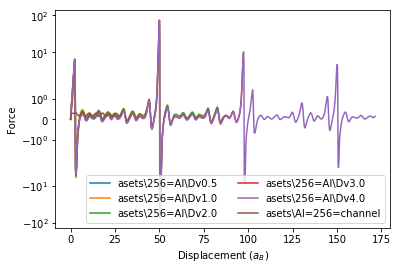

In [4]:
fig, ax = plt.subplots()

plot_max = 3000
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)
ax.set_yscale('symlog')
    
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

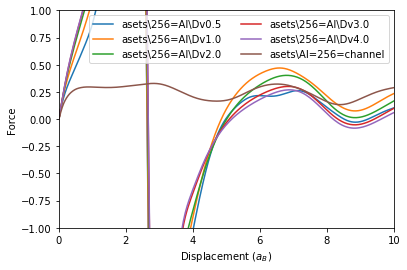

In [6]:
fig, ax = plt.subplots()

plot_max = -1
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)

ax.set_xlim(0, 10)

ax.set_ylim(-1, 1)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

Andre uses 6 $a_B$

In [7]:
data.query('displacement >= 6', inplace=True)

## Generate Features
Use the same features at the Al model

In [ ]:
featurizers = pkl.load(open('featurizers.pkl'))

In [ ]:
%%time
for f in featurizers:
    data = f.featurize_dataframe(data, 'atoms', n_jobs=None)

In [ ]:
X_cols = sum([f.feature_labels() for f in featurizers], [])
y_col = 'force'

## Fit on Entire Dataset
Use the Bayesian Ridge Regression model from previous examples. 

In [ ]:
model = pkl.load(open('best_model.pkl', 'rb'))

In [ ]:
model.steps[0][1].degree = 3

In [ ]:
model

In [ ]:
def fit_on_whole_dataset(model):

    model.fit(data[X_cols], data[y_col])
    data['force_fit'] = model.predict(data[X_cols])

    fig, ax = plt.subplots(1, 2)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        velocity.append(float(gid[-3:]))
        
        # Plot the performance
        my_line, = ax[0].plot(group['displacement'], group['force'], linestyle='--', label='v='+gid[-3:])

        ax[0].plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)
        
        ax[0].set_xlim(30, 40)
        ax[0].set_ylim(-0.3, 0.7)
        ax[0].legend(ncol=2)

        ax[0].set_xlabel('Displacement (a.u.)')
        ax[0].set_ylabel('Force ($E_H / a_B$)')
        
        # Plot the mean velocity
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    ax[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    ax[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    ax[1].set_ylabel('Stopping Power ($E_H / a_B$)')
    ax[1].set_xlabel('Velocity (au.)')
    ax[1].set_ylim(0, max(ax[1].get_ylim()))
    ax[1].set_xlim(0, 4.2)
    ax[1].legend()
    
    fig.tight_layout()
    
    return fig, ax

In [ ]:
fit_on_whole_dataset(model)

You'll note the model predictions (thick, translucent lines) do not really differ based on velocity, and nor do the predicted stopping powers

## Add Velocity as a Variable
Can we fit the data if we add exponentials of velocity as inputs. These exponentials should have the correct limiting behavior

In [ ]:
data['velocity_mag'] = data['velocity'].apply(np.linalg.norm)

In [ ]:
X_cols += ['velocity_mag',]

In [ ]:
for i in range(-2, 2):
    if i != 0:
        a = 'velocity_mag_exp=%i'%i
        data[a] = np.exp(i * data['velocity_mag'])
        X_cols += [a,]

In [ ]:
fig, ax = fit_on_whole_dataset(model)

fig.savefig('figures/Al_all_velocities.png', dpi=320)
fig.savefig('figures/Al_all_velocities.pdf')

The predictions do at least change significantly with the velocity, but not very well

In [ ]:
fit_on_whole_dataset(MLPRegressor(activation='tanh', hidden_layer_sizes=(128,64,32,16)))

With a somewhat complex NN model, we can at least fit the data

In [ ]:
data[['directory',] + X_cols + [y_col,]].to_csv('Al_all_velocities.csv', index=False)

## Leave-one-velocity-out Cross-Validation
Can we interpolate between different velocities?